# Exploring data and features

## Core Features that could be added:

### Price-Based Features:

- Returns: 1-day, 3-day, 5-day, 10-day returns
- Price ratios: Current price / MA(5), Current price / MA(20)
- Gap features: (Open - Previous Close) / Previous Close
- Intraday range: (High - Low) / Close

### Volume Features:

- Volume ratios: Current volume / MA(20 volume)
- Price-volume: Return * Volume (captures momentum with conviction)

### Technical Indicators:

- RSI (14-day) - momentum oscillator
- MACD signal (12,26,9) - trend following
- Bollinger Band position: (Price - BB_lower) / (BB_upper - BB_lower)

### Market Context:

- VIX level (fear index)
- Sector/market performance: Stock return vs S&P 500 return
- Day of week dummy variables

### Target Variable:

- Binary: 1 if next day's close > today's close, 0 otherwise

# Load csv data

In [1]:
import pandas as pd

data = pd.read_csv("../data/interim/data_with_target.csv", index_col=0)


In [247]:
data

,Date,Ticker,Close,High,Low,Open,Volume,WTI_Oil,US10Y,VIX,DJI,GSPC,NDX,RUT,Target
0,2020-01-02,AAPL,72.538513,72.598892,71.292304,71.545890,135480400,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
1,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.750000,80580000,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
2,2020-01-02,BA,331.348572,331.378393,325.761816,326.606765,4544400,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,1
3,2020-01-02,BAC,30.920326,30.937678,30.616677,30.668729,37614200,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
4,2020-01-02,BHP,33.608608,33.822793,33.522936,33.792196,1382193,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28929,2024-12-31,T,22.028353,22.105747,21.863890,21.883239,22342800,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1
28930,2024-12-31,VTI,287.925415,290.240280,287.190237,289.912409,3893200,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1
28931,2024-12-31,XOM,104.669357,104.990461,102.927624,103.307107,12387800,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1
28932,2024-12-31,^TNX,4.573000,4.587000,4.521000,4.529000,0,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1


# Add features
Doing this before one-hot encoding stocks will make it easier for calculations

In [2]:
macro_tickers = ['VIX', 'WTI_Oil', 'US10Y']  # VIX, WTI Oil, 10Y Treasury

data['VIX_ret'] = data['VIX'].pct_change()
data['WTI_ret'] = data['WTI_Oil'].pct_change()
data['TNX_ret'] = data['US10Y'].pct_change()

data['VIX_5d_mean'] = data['VIX'].rolling(5).mean()
data['WTI_5d_std'] = data['WTI_Oil'].rolling(5).std()

In [3]:
market_indices = ["GSPC", "NDX", "RUT", "DJI"]

for idx in market_indices:
    data[f'{idx}_return_1d'] = data[idx].pct_change()
    data[f'{idx}_return_5d'] = data[idx].pct_change(5)

In [29]:
import talib

data['return_1d'] = data.groupby('Ticker')['Close'].pct_change()
data['return_3d'] = data.groupby('Ticker')['Close'].pct_change(3)
data['return_5d'] = data.groupby('Ticker')['Close'].pct_change(5)
data['return_10d'] = data.groupby('Ticker')['Close'].pct_change(10)

data['rolling_std_5'] = data['Close'].rolling(window=5).std()
data['rolling_std_10'] = data['Close'].rolling(window=10).std()

data['ma_5'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=5).mean())
data['ma_20'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())

data['price_ma5_ratio'] = data['Close'] / data['ma_5']
data['price_ma20_ratio'] = data['Close'] / data['ma_20']

data['volume_ratio'] = (
    data['Volume'] / 
    data.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
)

data['price_volume'] = data['return_1d'] * data['Volume']

data['rsi'] = data.groupby('Ticker')['Close'].transform(
    lambda x: talib.RSI(x.values, timeperiod=14)
)

data['macd'] = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean() - x.ewm(span=26, adjust=False).mean())
data['macd_signal'] = data.groupby('Ticker')['macd'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
data['macd_hist'] = data['macd'] - data['macd_signal'] 

In [30]:
# True Range
data['tr'] = data['High'] - data['Low']
data['tr1'] = abs(data['High'] - data['Close'].shift(1))
data['tr2'] = abs(data['Low'] - data['Close'].shift(1))
data['true_range'] = data[['tr','tr1','tr2']].max(axis=1)

# ATR with 14-day window
data['ATR_14'] = data['true_range'].rolling(window=14).mean()

# Drop intermediate columns
data.drop(columns=['tr','tr1','tr2','true_range'], inplace=True)



# 20-day moving average
data['MA20'] = data['Close'].rolling(window=20).mean()
# 20-day standard deviation
data['STD20'] = data['Close'].rolling(window=20).std()

# Upper & lower bands
data['BB_upper'] = data['MA20'] + (2 * data['STD20'])
data['BB_lower'] = data['MA20'] - (2 * data['STD20'])

# Bandwidth (upper - lower) / moving average
data['BB_width'] = (data['BB_upper'] - data['BB_lower']) / data['MA20']

# Optional: drop intermediate columns
data.drop(columns=['MA20','STD20','BB_upper','BB_lower'], inplace=True)


In [206]:
data

,Date,Ticker,Close,High,Low,Open,Volume,Close_WTI_Oil,Close_US10Y,Close_VIX,...,ma_5,ma_20,price_ma5_ratio,price_ma20_ratio,volume_ratio,price_volume,rsi,macd,macd_signal,macd_hist
0,2020-01-02,AAPL,72.538513,72.598892,71.292304,71.545890,135480400,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.750000,80580000,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2,2020-01-02,BA,331.348572,331.378393,325.761816,326.606765,4544400,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
3,2020-01-02,BAC,30.920328,30.937680,30.616679,30.668731,37614200,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
4,2020-01-02,BHP,33.608612,33.822797,33.522940,33.792200,1382193,61.180000,1.882,12.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28929,2024-12-31,T,22.028353,22.105747,21.863890,21.883239,22342800,71.720001,4.573,17.35,...,22.086399,22.385818,0.997372,0.984032,0.615997,158107.574053,47.674542,-0.020294,0.055084,-0.075379
28930,2024-12-31,VTI,287.925415,290.240280,287.190237,289.912409,3893200,71.720001,4.573,17.35,...,291.911316,294.711401,0.986346,0.976974,1.229428,-13520.654188,40.698731,-0.552695,0.457792,-1.010487
28931,2024-12-31,XOM,104.669365,104.990468,102.927632,103.307115,12387800,71.720001,4.573,17.35,...,103.667140,106.728794,1.009668,0.980704,0.723517,212006.506014,34.801201,-2.795823,-2.806249,0.010427
28932,2024-12-31,^TNX,4.573000,4.587000,4.521000,4.529000,0,71.720001,4.573,17.35,...,4.581400,4.401200,0.998166,1.039035,NaN,0.000000,63.362347,0.086270,0.070208,0.016062


In [31]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode stock symbols (will need to normalize features within each stock 
# to account for different scales instead when adding more stocks to dataset)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_values = encoder.fit_transform(data[['Ticker']])
new_cols = encoder.get_feature_names_out(['Ticker'])

df_encoded = pd.DataFrame(encoded_values, columns=new_cols, index=data.index)

df = pd.concat(
    [data.drop(columns=['Ticker']), df_encoded],
    axis=1
)

In [21]:
df

,Date,Close,High,Low,Open,Volume,WTI_Oil,US10Y,VIX,DJI,GSPC,NDX,RUT,Target,VIX_ret,WTI_ret,TNX_ret,VIX_5d_mean,WTI_5d_std,GSPC_return_1d,GSPC_return_5d,NDX_return_1d,NDX_return_5d,RUT_return_1d,RUT_return_5d,DJI_return_1d,DJI_return_5d,return_1d,return_3d,return_5d,return_10d,ma_5,ma_20,price_ma5_ratio,price_ma20_ratio,volume_ratio,price_volume,rsi,macd,macd_signal,macd_hist,ATR_14,BB_width,Ticker_AAPL,Ticker_AMZN,Ticker_BA,Ticker_BAC,Ticker_BHP,Ticker_DIS,Ticker_GOOG,Ticker_IWM,Ticker_JNJ,Ticker_JPM,Ticker_KO,Ticker_MSFT,Ticker_NEE,Ticker_NVDA,Ticker_PFE,Ticker_QQQ,Ticker_SPY,Ticker_T,Ticker_VTI,Ticker_XOM
0,2020-01-02,72.538521,72.598899,71.292311,71.545897,135480400,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,2,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-02,331.348572,331.378393,325.761816,326.606765,4544400,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,2,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-02,30.920332,30.937684,30.616682,30.668735,37614200,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-02,33.608608,33.822793,33.522936,33.792196,1382193,61.180000,1.882,12.47,28868.800781,3257.850098,8872.219727,1666.770020,0,0.0,0.0,0.0,12.47,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25155,2024-12-31,509.896118,516.309303,508.928648,515.551337,29117000,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1,0.0,0.0,0.0,17.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.008495,-0.034686,-0.022262,-0.048527,520.430530,521.716696,0.979758,0.977343,0.966919,-247340.540242,44.908909,2.612441,4.733597,-2.121156,149.444374,3.284233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25156,2024-12-31,582.599915,587.132835,580.949738,586.407129,57052700,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1,0.0,0.0,0.0,17.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003638,-0.025377,-0.014478,-0.030880,590.860559,594.672549,0.986019,0.979699,1.110222,-207559.756570,41.593611,-0.428328,1.330239,-1.758567,151.849140,3.280292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25157,2024-12-31,22.028353,22.105747,21.863890,21.883239,22342800,71.720001,4.573,17.35,42544.218750,5881.629883,21012.169922,2230.159912,1,0.0,0.0,0.0,17.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007077,-0.008275,-0.003065,-0.003065,22.086398,22.385818,0.997372,0.984032,0.615997,158109.536105,47.674544,-0.020294,0.055084,-0.075379,182.326182,3.279977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25158,2024-12-31,287.925415,290.240280,287.190237,289.912409,3893200,71.720001,4

# Handle NaNs

XGBoost can handle NaNs in features, except in the target variable. For now I will fill them anyway.

In [32]:
df.bfill(inplace=True)

# Split training/test data

In [ ]:
from sklearn.model_selection import train_test_split

tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "JPM", "BAC", "JNJ", "PFE", "DIS", "KO", "BA", "XOM", "BHP", "NEE", "T", "SPY", "QQQ", "IWM", "VTI"]
ticker_columns = [col for col in df.columns if col.startswith('Ticker_')]
macro_features = ['VIX_ret', 'WTI_ret', 'TNX_ret', 'VIX_5d_mean', 'WTI_5d_std']
feature_columns = ['return_1d', 'return_3d', 'return_5d', 'volume_ratio', 'rsi', 'macd', 'macd_hist', 'price_ma5_ratio', 'price_ma20_ratio', 'price_volume', 'rolling_std_5', 'rolling_std_10', 'ATR_14', 'BB_width'] + ticker_columns + macro_features

X = df[feature_columns]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check for class imbalances

In [24]:
print("\nTraining set class distribution:")
train_counts = y_train.value_counts(normalize=True)
print(f"Class -1: {train_counts.get(0, 0):.1%}, "
      f"Class 0: {train_counts.get(1, 0):.1%}, "
      f"Class 1: {train_counts.get(2, 0):.1%}")

print("\nTest set class distribution:")
test_counts = y_test.value_counts(normalize=True)
print(f"Class -1: {test_counts.get(0, 0):.1%}, "
      f"Class 0: {test_counts.get(1, 0):.1%}, "
      f"Class 1: {test_counts.get(2, 0):.1%}")


Training set class distribution:
Class -1: 43.6%, Class 0: 6.3%, Class 1: 50.1%

Test set class distribution:
Class -1: 39.6%, Class 0: 9.1%, Class 1: 51.3%


## Calculate class weight

In [34]:
import numpy as np

class_counts = y_train.value_counts().to_dict()
n_total = len(y_train)
n_classes = len(class_counts)

# Compute weights
class_weights = {cls: n_total / (count * n_classes) for cls, count in class_counts.items()}
print("Class weights:", class_weights)


Class weights: {2: 0.6652784663691952, 0: 0.7641609719058466, 1: 5.312219583003431}


# Train model

## Hyperparameter tuning

In [10]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.5, 1.0]
}

# Need TimeSeriesSplit for financial data
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=param_dist,
    n_iter=30,
    scoring='balanced_accuracy',
    cv=tscv,
    verbose=1, 
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


KeyboardInterrupt: 

## Feature selection based on performance

In [11]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, balanced_accuracy_score

base_features = feature_columns
candidate_feature_sets =  [[], ['VIX_5d_mean', 'WTI_5d_std']]

for ft in candidate_feature_sets:
    model = XGBClassifier(
        eval_metric='logloss',
        random_state=42,

        # Obtained from hyperparameter tuning
        subsample=0.9,
        reg_lambda=1.0,
        reg_alpha=0,
        n_estimators=100,
        min_child_weight=5,
        max_depth=4,
        learning_rate=0.05,
        colsample_bytree=0.8
    )

    X1 = df[base_features + ft]
    y1 = df['Target']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle=False)

    weights = y1_train.map(class_weights)

    model.fit(X1_train, y1_train, sample_weight=weights)

    y1_pred = model.predict(X1_test)

    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X1, y1, cv=tscv,
                                scoring=make_scorer(balanced_accuracy_score))
    print('Added features: ' + str(ft))
    print('Balanced CV Accuracy:', scores.mean())

KeyboardInterrupt: 

In [43]:
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import make_scorer

model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,

    n_estimators=300,         # more boosting rounds
    learning_rate=0.15,       # smaller learning rate
    max_depth=5,              # control overfitting
    min_child_weight=1,       # minimum data per leaf
    subsample=0.8,            # row sampling
    colsample_bytree=0.8,     # feature sampling
    gamma=1,                  # regularization for splits
    reg_lambda=2 
)

weights = y_train.map(class_weights)

# Train the model
model.fit(X_train, y_train, sample_weight=weights)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

## Evaluate performance

Accuracy: 0.4344
Balanced CV Accuracy: 0.3376

Classification Report:
              precision    recall  f1-score   support

        Down       0.40      0.39      0.40      1995
        Flat       0.10      0.09      0.09       457
          Up       0.51      0.53      0.52      2580

    accuracy                           0.43      5032
   macro avg       0.34      0.34      0.34      5032
weighted avg       0.43      0.43      0.43      5032


Confusion Matrix:


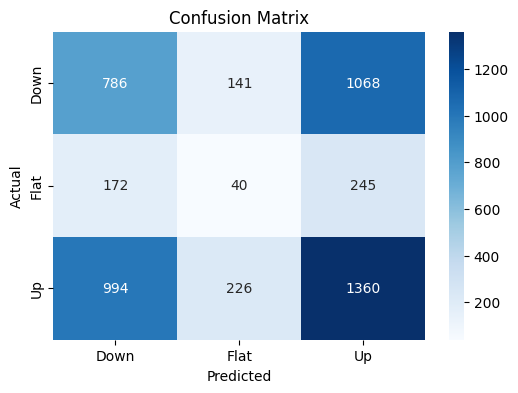

In [44]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Basic accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Balanced CV Accuracy
tscv = TimeSeriesSplit(n_splits=3)
scores = cross_val_score(
    model, X, y, cv=tscv, scoring=make_scorer(balanced_accuracy_score)
)
print(f"Balanced CV Accuracy: {scores.mean():.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Flat", "Up"]))

# Confusion Matrix with labels
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down", "Flat", "Up"],
            yticklabels=["Down", "Flat", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Feature correlation

Return feature correlations:
           return_1d  return_3d  return_5d
return_1d   1.000000   0.649080   0.522679
return_3d   0.649080   1.000000   0.769008
return_5d   0.522679   0.769008   1.000000


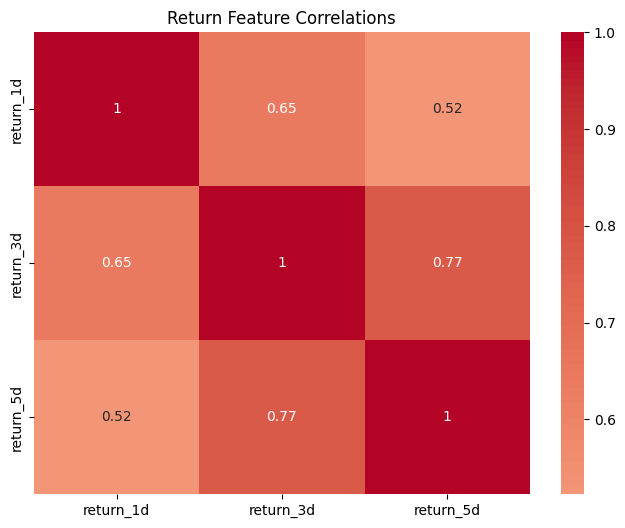

In [324]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlation between your return features
return_features = ['return_1d', 'return_3d', 'return_5d']
correlation_matrix = X_train[return_features].corr()

print("Return feature correlations:")
print(correlation_matrix)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Return Feature Correlations')
plt.show()

## Feature importance

In [325]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
importance_df.head(10).plot(x='feature', y='importance', kind='bar')
plt.title('Top 10 Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length

## Model validation

In [1]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# Use TimeSeriesSplit for financial data (respects temporal order)
tscv = TimeSeriesSplit(n_splits=5)

# Cross-validation scores
cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

NameError: name 'model' is not defined